# Importing Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from matplotlib.dates import MonthLocator, DateFormatter
from dataclasses import dataclass
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
import os
import joblib

# Importing data

In [2]:
# number of days to forecast
forecasting_days = 90

In [3]:
path = '1. Preprocessing/'
df = pd.read_csv(path + 'Preprocessed_df.csv' , parse_dates=['Date'])
tf.random.set_seed(3) 

cols_dtype = df.columns.drop('Date')
df[cols_dtype] = df[cols_dtype].astype(int)

print(df.shape)
df.head()

(533, 7)


,Date,ActiveCustomer,Churned,DealsAdded,Leads,NewPaid,ClosedDeals
0,2022-03-21,1183,0,3565,19,1,1196
1,2022-03-22,1097,2,774,20,1,478
2,2022-03-23,946,0,997,20,1,458
3,2022-03-24,918,0,590,19,0,370
4,2022-03-25,857,5,498,17,0,282


In [4]:
# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    WINDOW_SIZE = 50 # values such as 60 and 90 should be checked
    BATCH_SIZE = 44 # other values should be checked
    SHUFFLE_BUFFER_SIZE = 1000

# Model Structure

In [5]:
tf.keras.backend.clear_session()
def create_uncompiled_model_ConvLSTM():
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=70, kernel_size=7,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[G.WINDOW_SIZE, 1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(210, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
        tf.keras.layers.Dropout(0.01),
        tf.keras.layers.Dense(16 , activation = 'relu'),
        # tf.keras.layers.Dense(10 , activation = 'relu'),
        tf.keras.layers.Dense(1 , activation = 'linear'),

    ])
    
    return model

In [6]:
optimal_model = create_uncompiled_model_ConvLSTM()
optimal_model.load_weights('Optimal Model/Optimal_Model.h5')

In [7]:
scaler = joblib.load('Optimal Model/min_max_scaler.pkl')
x_final = df.loc[:, 'ActiveCustomer'].to_numpy().reshape(-1,1)
x_final = scaler.transform(x_final).squeeze()

# Prediction

In [8]:
from datetime import timedelta

forecast_df = pd.DataFrame(np.zeros((forecasting_days , 2)) , columns = ['Date' , 'Predicted_ActiveCustomer'])

def predict_one_step(model, input_data):
    input_data = np.array(input_data).reshape(1, G.WINDOW_SIZE, 1)
    prediction = model.predict(input_data)[0, 0]
    return prediction

# Initialize input_data with the last G.WINDOW_SIZE values from your historical data
input_data = list(x_final[-G.WINDOW_SIZE:])

# Generate a list of dates for the next 90 days
last_date = df['Date'].iloc[-1]
next_dates = [last_date + timedelta(days=i) for i in range(1, forecasting_days + 1)]
forecast_df['Date'] = next_dates
forecast_df.set_index('Date', inplace=True)

# Perform sequential forecasting for 90 days
for date in next_dates:
    # Predict one step ahead
    next_day_prediction = predict_one_step(optimal_model, input_data)
    
    # Append the predicted value and date to the DataFrame
    forecast_df.loc[date, 'Predicted_ActiveCustomer'] = next_day_prediction
    
    # Append the predicted value to the input data for the next prediction
    input_data.append(next_day_prediction)
    
    # Remove the oldest value to maintain the window size
    input_data.pop(0)

# Inverse transform the predicted values to the original scale
forecast_df['Predicted_ActiveCustomer'] = scaler.inverse_transform(np.array(forecast_df['Predicted_ActiveCustomer']).reshape(-1, 1)).squeeze()

forecast_df

,Predicted_ActiveCustomer
Date,
2023-09-05,2040.619767
2023-09-06,2046.024362
2023-09-07,2048.808754
2023-09-08,2048.676101
2023-09-09,2049.548546
...,...
2023-11-29,2302.459488
2023-11-30,2306.234644
2023-12-01,2309.924120


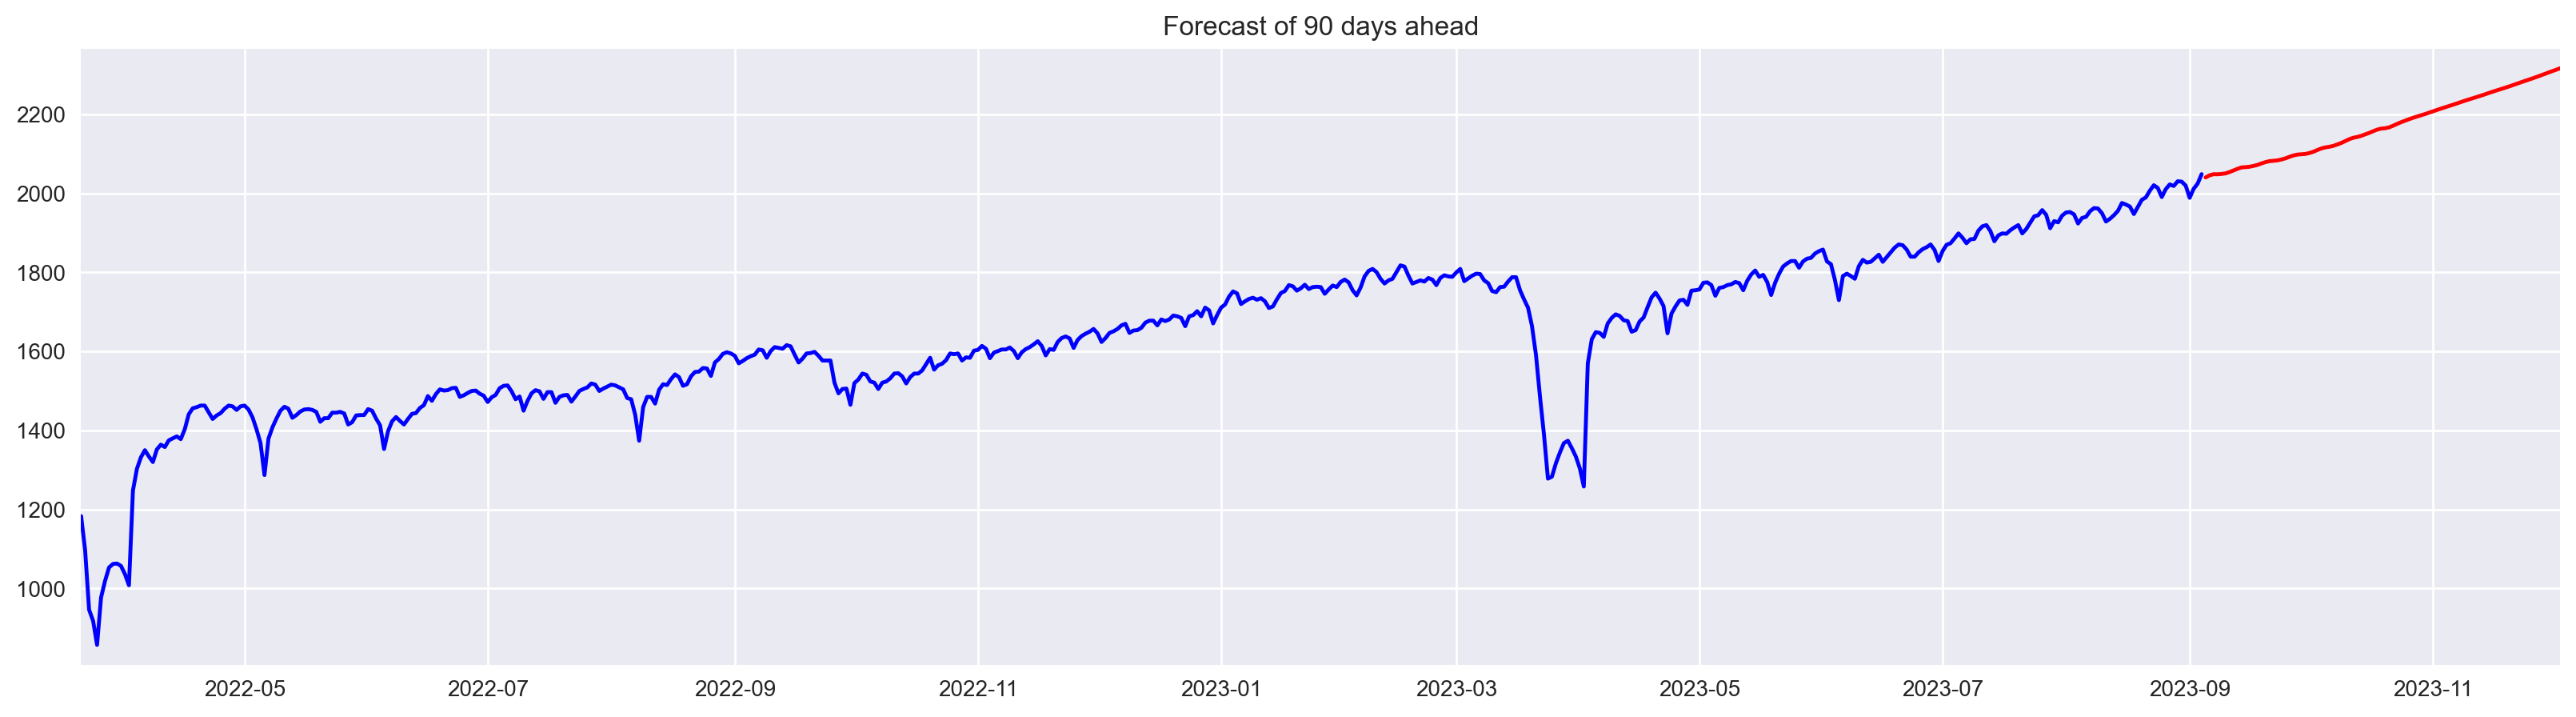

In [9]:
plt.style.use('seaborn')
plt.figure(figsize=(20, 5), dpi=200)
plt.plot(df['Date'], df['ActiveCustomer'] , color= 'blue')
plt.plot(forecast_df.index , forecast_df['Predicted_ActiveCustomer'] , color = 'red')

ymin = min(df['ActiveCustomer'].min() , forecast_df['Predicted_ActiveCustomer'].min())
ymax = max(df['ActiveCustomer'].max() , forecast_df['Predicted_ActiveCustomer'].max())
plt.ylim([ymin-50 , ymax+50])
plt.xlim([df.loc[0,'Date'] , forecast_df.index[-1]])

plt.title('Forecast of 90 days ahead')

plt.show()

Saving the Results

In [10]:
forecast_df = forecast_df.reset_index().rename(columns = {'Predicted_ActiveCustomer': 'ActiveCustomer'})
forecast_df['ActiveCustomer'] = np.around(forecast_df['ActiveCustomer'])
historical_and_forecast = pd.concat([df[['Date' , 'ActiveCustomer']] ,
                                     forecast_df])

In [11]:
os.makedirs('2. Univariate TS Models' , exist_ok=True)

In [12]:
excel_file_path = '2. Univariate TS Models/ModelPrediction.xlsx'
writer = pd.ExcelWriter(excel_file_path, engine='xlsxwriter')

historical_and_forecast.to_excel(writer, sheet_name='Historical + Forecast Data', index=False)
forecast_df.to_excel(writer, sheet_name='Forecast Data', index=False)

writer.save()